#### barb_0MMPG_GF

In [2]:
import time
from collections import namedtuple

try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

import scipy.ndimage

try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mticker

#from ipywidgets import *
try:
    import cv2
except:
    !pip install cv2
    import cv2
    
#import kernels
try:
    from skimage import io as skimage_io
except:
    !pip install scikit-image
    from skimage import io as skimage_io

try:
    import information_theory as IT
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    import information_theory as IT

import utils

In [3]:
# apt install cm-super-minimal
# apt install dvipng
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Helvetica",
    "font.family": "Serif",
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amsfonts}"
})

In [4]:
import logging
logging.basicConfig(format="[%(filename)s:%(lineno)s %(funcName)s()] %(message)s")
logger = logging.getLogger(__name__)

In [5]:
try:
    import denoising.image.gaussian as denoising
except:
    !pip install "denoising @ git+https://github.com/vicente-gonzalez-ruiz/denoising"
    import denoising.image.gaussian as denoising

In [6]:
denoiser = denoising.Monochrome_Denoising(logger)

In [7]:
def get_gaussian_kernel(sigma=1):
    number_of_coeffs = 3
    number_of_zeros = 0
    while number_of_zeros < 2 :
        delta = np.zeros(number_of_coeffs)
        delta[delta.size//2] = 1
        coeffs = scipy.ndimage.gaussian_filter1d(delta, sigma=sigma)
        number_of_zeros = coeffs.size - np.count_nonzero(coeffs)
        number_of_coeffs += 1
    return coeffs[1:-1]

1.0000000000000002


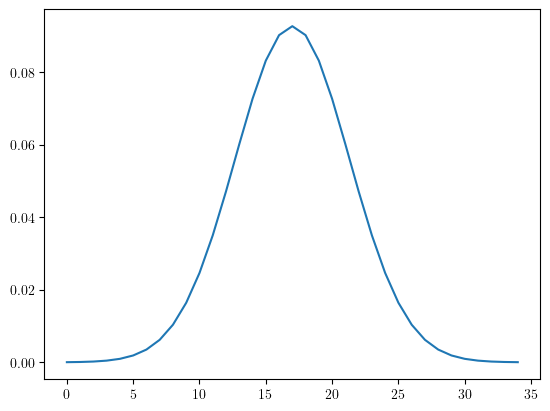

In [8]:
sigma_kernel = 4.3
sigma = np.array([sigma_kernel, sigma_kernel])
kernel = [None]*2
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
print(np.sum(kernel[0]))
plt.plot(kernel[0])
plt.show()

In [9]:
Args = namedtuple("args", ["input"])
args = Args("barb_0MMPG.png")

In [10]:
try:
    Y = skimage_io.imread(args.input)
except FileNotFoundError:
    %run barb_0MMPG.ipynb
    Y = skimage_io.imread(args.input)

In [11]:
logger.setLevel(logging.INFO)
denoised = denoiser.filter(Y, kernel)

[gaussian.py:20 filter()] filtering along Y
[gaussian.py:22 filter()] done
[gaussian.py:23 filter()] filtering along X
[gaussian.py:25 filter()] done


In [12]:
Y.shape

(512, 512)

In [14]:
Args = namedtuple("args", ["input"])
args = Args("barb.png")

In [15]:
try:
    X = skimage_io.imread(args.input)
except FileNotFoundError:
    %run barb.ipynb
    X = skimage_io.imread(args.input)

In [16]:
PSNR = IT.distortion.PSNR(denoised, X)

In [18]:
STD_DEV = 40

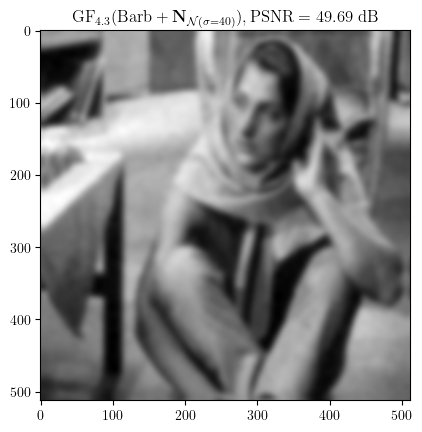

In [19]:
#plt.title(r"$\mathrm{GF}_{\text{" + str(sigma_kernel) + r"}}(\mathrm{Barb} + \mathbf{N}_{\mathcal{N}}), \mathbf{N}\sim \mathcal{N}_{}" + rf"(\mu=0, \sigma={std_dev})," + r"\mathrm{PSNR}=" + f"{PSNR:.2f}" + r"~\mathrm{dB}$")
string  = r"$"
string += r"\mathrm{GF}"
string += r"_\text{"
string += str(sigma_kernel)
string += r"}"
string += r"(\text{Barb} + \mathbf{N}_{\mathcal{N}(\sigma="
string += str(STD_DEV)
string += r")})"
string += r", \mathrm{PSNR}="
string += f"{PSNR:.2f}"
string += r"~\mathrm{dB}"
string += r"$"
plt.title(string)
plt.imshow(denoised, cmap="gray")
plt.savefig('barb_0MMPG_GF.pdf', bbox_inches='tight')

In [20]:
plt.imshow(fsc.log_abs(fsc.ft2(denoised)))

NameError: name 'fsc' is not defined

#### GF_PCC_0MAGN_barb
Shows the impact of the length of the filter (sigma_kernel) for different noise levels (std_dev).

In [ ]:
sigmas_kernel = [0.25, 0.35, 0.5, 0.65, 0.75, 0.9, 1.0, 1.5]
sigmas_kernel = [0.5 + i/5 for i in range(30)] # 30
std_devs = [i for i in range(0, 120, 20)]
PCC_curves = []
#sigma_index = 1
#for std_dev in range(10, 50, int((50-10)/len(sigmas_kernel))):
for std_dev in std_devs:
    Y = X + np.random.normal(loc=0, scale=std_dev, size=X.shape).reshape(X.shape)
    #Y = np.clip(a = Y, a_min=0, a_max=255)
    PCC_curve = []
    for sigma_kernel in sigmas_kernel: #range(5, 20, 1):
        #sigma_kernel /= 10
        sigma = np.array([sigma_kernel, sigma_kernel])
        kernel = [None]*2
        kernel[0] = get_gaussian_kernel(sigma[0])
        kernel[1] = get_gaussian_kernel(sigma[1])
        denoised = denoiser.filter(Y, kernel)
        #PSNR = IT.distortion.PSNR(denoised, X)
        PCC = np.corrcoef(denoised.flatten(), X.flatten())[0, 1]
        print(std_dev, sigma_kernel, PCC)
        PCC_curve.append(PCC)
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    PCC_curves.append(PCC_curve)
    #sigma_index += 1
    print()

In [ ]:
plt.title(r'$\mathbf{X}=\mathrm{Barb}$')
#plt.title(r"$\mathbb{E}_{\text{" + str(iters) + r"}}(\mathbf{N}" + rf"/{_lambda}" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\mathrm{Barb})$")
#plt.title("Averaging Poisson noisy instances of \"Barb\"")
for i in range(len(PCC_curves)):
    #plt.plot([j/10 for j in range(5, 20, 1)], curves[i], label=rf"$\sigma={10+i*5}$")
    plt.plot(sigmas_kernel,
             PCC_curves[i],
             label=rf"$\sigma={std_devs[i]}$"
             + r"$, \tau^*="
             + rf"{sigmas_kernel[np.argmax(PCC_curves[i])]}$")
#plt.ylabel(r"$\mathrm{PCC}(\mathbf{X}, \hat{\mathbf{X}})$")
plt.ylabel(r"$\mathrm{PCC}(\mathbf{X}, \mathrm{GF}_\tau(\mathbf{X}+\mathbf{N}_{\mathcal{N}(\sigma)}))$")
#plt.xlabel(r"$\tau~(\text{Standard deviation of the Gaussian kernel})$")
plt.xlabel(r"$\tau$")
plt.legend()
#plt.show()
plt.savefig("GF_PCC_0MMPG_barb.pdf", bbox_inches='tight')

#### GF_SFRC_0MAGN_barb

In [ ]:
STD_DEV = 80

In [ ]:
SFRC_curve = []
sigmas_kernel = [0.25, 0.5, 0.75, 1.0, 1.2, 1.5, 1.6, 2.0, 2.5]
sigmas_kernel = [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.50, 2.75, 5]
#sigmas_kernel = [0.01, 0.5, 1.0, 1.25, 1.3, 1.35]
Y = X + np.random.normal(loc=0, scale=STD_DEV, size=X.shape).reshape(X.shape) # Mover fuera!!!!
#Y = np.clip(a = Y, a_min=0, a_max=255)
for i in sigmas_kernel:
    total_c_avg = 0
    kernel = [None]*2
    kernel[0] = get_gaussian_kernel(i)
    kernel[1] = get_gaussian_kernel(i)
    #total_c_avg = np.zeros(X.shape[0]>>1)
    #for j in range(1):
    denoised = denoiser.filter(Y, kernel)
    freq, c_avg = fsc.get_SFRC_curve__chessboard(denoised)
    #c_avg = fsc.single_image_frc(denoised, X.shape[0]/2)
    #freq = fsc.get_radial_spatial_frequencies(denoised, 1)
    #freq = freq[:(len(freq)>>1)]
    #c_avg = c_avg[:(len(c_avg)>>1)]
    #freq, c_avg = fsc.get_SFRC_curve(X)
    print(len(c_avg))
    #total_c_avg += c_avg
    #SFRC_curve.append(total_c_avg/1)
    SFRC_curve.append(c_avg)
    print(i, end=' ')

# Ideal curve
#freq, c_avg = fsc.get_SFRC_curve(X)
#freq = freq[:(len(freq)>>1)]
#c_avg = c_avg[:(len(c_avg)>>1)]
#SFRC_curve.append(c_avg)
#sigmas_kernel.append("orig")

In [ ]:
string  = r"$\mathbf{X}=\mathrm{Barb}$"
plt.title(string)
#plt.xlabel("Normalized spatial frequency")
plt.xlabel(r"$\omega$")
#plt.ylabel(r"$\mathrm{SFRC}(\tilde{\mathbf{X}})$")
plt.ylabel(r"$\mathrm{SFRC}(\mathrm{GF}_\tau(\mathbf{X}+\mathbf{N}_{\mathcal{N}(\sigma=" + rf"{STD_DEV}" + ")}))$")
markers = ['o', 's', '^', 'd', 'x', '*', 'v', 'p', 'h', '+']  # Add more markers if needed
#for i in range(len(sigmas_kernel)-1, 0, -1):
for i in range(len(sigmas_kernel)):
    plt.plot(freq[:(len(freq)>>0)],
             SFRC_curve[i][:(len(freq)>>0)],
             label=r"$\tau=" + f"{sigmas_kernel[i]}"
             + rf", {np.sum(SFRC_curve[i][:(len(freq)>>1)]):.2f}" # [:(len(freq)>>1)]
             + rf", {np.min(SFRC_curve[i]):.2f}"
             #+ rf", {(np.sum(SFRC_curve[i][:(len(freq)>>1)]) + np.sum(SFRC_curve[i][(len(freq)>>1):]):.2f)}"
             #+ rf", {np.sum(SFRC_curve[i]):.2f}"
             + r"$",
             marker=markers[i % len(markers)],
             markersize=0.0)
Y = X + np.random.normal(loc=0, scale=STD_DEV, size=X.shape).reshape(X.shape)
plt.plot(freq[:(len(freq)>>0)],
         fsc.get_SFRC_curve__chessboard(X)[1],
         label="No noise")
plt.plot(freq[:(len(freq)>>0)],
         fsc.get_SFRC_curve__chessboard(Y)[1],
         label=f"noise {STD_DEV}")
plt.legend()
plt.savefig("GF_SFRC_0MAGN_barb.pdf", bbox_inches='tight')

Heurística: aplicamos un tau grande (5, por ejemplo) y miramos el valor mínimo que toma la curva SFRC. Luego empezamos a usar tau's de pequeñas a grandes, y cuando alcanzamos un valor mínimo próximo a obtenido por tau grande, ese es el tau buscado.

In [ ]:
min_sigma_kernel = 0.5
max_sigma_kernel = 2.0
area_per_sigma_kernel_curves = []
std_devs = []
for s in range(20, 100, 20):
    std_devs.append(s)
    sigmas_kernel = []
    area_per_sigma_kernel_curve = []
    Y = X + np.random.normal(loc=0, scale=s, size=X.shape).reshape(X.shape) # Mover fuera!!!!
    for i in range(10):
        sigma_kernel = min_sigma_kernel + i*(max_sigma_kernel - min_sigma_kernel)/10
        sigmas_kernel.append(sigma_kernel)
        kernel = [None]*2
        kernel[0] = get_gaussian_kernel(sigma_kernel)
        kernel[1] = get_gaussian_kernel(sigma_kernel)
        denoised = denoiser.filter(Y, kernel)
        freqs, c_avg = fsc.get_SFRC_curve__chessboard(denoised)
        area = np.sum(c_avg)
        area_per_sigma_kernel_curve.append(area)
    area_per_sigma_kernel_curves.append(area_per_sigma_kernel_curve)

In [ ]:
for i in range(len(area_per_sigma_kernel_curves)):
    plt.plot(
        sigmas_kernel,
        area_per_sigma_kernel_curves[i],
    label=f"{std_devs[i]}")
plt.legend()

En cuanto rebota, dividimos entre 2 tau y esa es la estimación para la longitud del filtro Gaussiano. Dicha estimación no depende del nivel de ruido (que es deconocido), sino de la imagen ruidosa en su conjunto.

In [ ]:
#input()

## Poisson noise (shot noise)
\begin{equation}
  Y=\frac{N}{\gamma},~N∼\mathcal{P}(λ=\gamma X),
\end{equation}
where:
* $X\ge 0$.
* $\lambda\in{\mathbb R}\ge 0$ is the rate of the Poisson distribution, resulting that $\lambda={\mathbb E}(N)=\text{Var}(N)$.

#### Poisson_barb

In [ ]:
gamma = 0.15
string  = r"$\mathbf{N}"
string += r"_{\mathcal{P}(\lambda="
string += rf"{gamma}"
string += r"\cdot\mathrm{Barb})}"
string += rf"/{gamma}"
string += r"$"
plt.title(string)
Y = np.random.poisson(X * gamma) / gamma
#Y = X + np.random.poisson(0.5*X)
#from skimage.util import random_noise
#Y = random_noise(X, mode="poisson")
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
plt.savefig('Poisson_barb.pdf', bbox_inches='tight')

#### GF_Poisson_barb

In [ ]:
denoised = denoiser.filter(Y, kernel)

In [ ]:
#plt.title(r"$\mathrm{GF}_{\text{" + str(sigma_kernel) + r"}}(\mathbf{N}" + rf"/{_lambda}" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\cdot\mathrm{Barb})$")
string  = r"$"
string += r"\mathrm{GF}"
string += r"_\text{"
string += str(sigma_kernel)
string += r"}"
string += r"(\mathbf{N}"
string += r"_{\mathcal{P}(\lambda="
string += rf"{gamma}"
string += r"\cdot\mathrm{Barb})}"
string += rf"/{gamma})"
string += r"$"
plt.title(string)
plt.imshow(denoised, cmap="gray")
plt.savefig('GF_Poisson_barb.pdf', bbox_inches='tight')

#### GF_PCC_Poisson_barb

In [ ]:
for gamma in range(len(sigmas_kernel)):
    print((1+gamma)/40)

In [ ]:
print([(0.25 + i/10) for i in range(20)])

In [ ]:
#sigmas_kernel = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
sigmas_kernel = [(0.25 + i/10) for i in range(20)]
curves = []
#sigma_index = 1
#for _lambda in range(10, 0, -int((10)/len(sigmas_kernel))):
#for _lambda in range(len(sigmas_kernel)):
for gamma in range(8):
    #gamma /= 40
    gamma = (1+gamma)/10
    curve = []
    for sigma_kernel in sigmas_kernel: #range(5, 20, 1):
        #sigma_kernel /= 10
        sigma = np.array([sigma_kernel, sigma_kernel])
        kernel = [None]*2
        kernel[0] = get_gaussian_kernel(sigma[0])
        kernel[1] = get_gaussian_kernel(sigma[1])
        Y = np.random.poisson(X.astype(np.float32) * gamma) / gamma
        Y = np.clip(a = Y, a_min=0, a_max=255)
        denoised = denoiser.filter(Y, kernel)
        #PSNR = IT.distortion.PSNR(denoised, X)
        PCC = np.corrcoef(denoised.flatten(), X.flatten())[0, 1]
        print(f"gamma={gamma}", f"sigma_kernel={sigma_kernel}", f"PCC={PCC}")
        curve.append(PCC)
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    curves.append(curve)
    #sigma_index += 1
    print()

In [ ]:
plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
for i in range(len(curves)):
    plt.plot(sigmas_kernel, curves[i], label=rf"$\gamma={(1+i)/40}$" + r"$, \mathrm{argmax}_\tau\mathrm{PCC}=" + rf"{sigmas_kernel[np.argmax(curves[i])]}$")
    #plt.plot([i/10 for i in range(5, 20, 1)], curves[i], label=rf"$\lambda={(10-i)/40}\cdot" + r"\mathrm{Barb}$")
string  = r"$"
string += r"\mathrm{PCC}"
string += r"(\mathbf{X}, "
string += r"\mathrm{GF}_\tau(\mathbf{N}_"
string += r"{\mathcal{P}(\gamma\mathbf{X})}/\gamma))$"
plt.ylabel(string)
plt.xlabel(r"$\tau$")
plt.legend()
#plt.show()
plt.savefig("GF_PCC_Poisson_barb.pdf", bbox_inches='tight')

#### GF_SFRC_Poisson_barb

In [ ]:
curve = []
gamma = 0.05
sigmas_kernel = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5]
for i in sigmas_kernel:
    total_c_avg = 0
    kernel = [None]*2
    kernel[0] = get_gaussian_kernel(i)
    kernel[1] = get_gaussian_kernel(i)
    total_c_avg = np.zeros(X.shape[0]>>2)
    for j in range(1):
        Y = np.random.poisson(X.astype(np.float32) * gamma) / gamma
        Y = np.clip(a = Y, a_min=0, a_max=255)
        denoised = denoiser.filter(Y, kernel)
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        freq, c_avg = fsc.get_SFRC_curve__chessboard(denoised)
        #freq, c_avg = fsc.get_SFRC_curve(X)
        freq = freq[:(len(freq)>>1)]
        c_avg = c_avg[:(len(c_avg)>>1)]
        total_c_avg += c_avg
    curve.append(total_c_avg/1)
    print(i, end=' ')

In [ ]:
plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.xlabel(r"$\omega$")
#plt.ylabel(r"$\mathrm{SFRC}(\tilde{\mathbf{X}})$")
string  = r"$\mathrm{SFRC}"
string += r"(\mathrm{GF}_\tau(\mathbf{N}"
string += r"_{\mathcal{P}("
string += rf"{gamma}"
string += r"\mathbf{X})}/" + rf"{gamma}" + r"))$"
plt.ylabel(string)
markers = ['o', 's', '^', 'd', 'x', '*', 'v', 'p', 'h', '+']  # Add more markers if needed
for i in range(len(sigmas_kernel)):
#for i in range(len(sigmas_kernel)-1, 0, -1):
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[i]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[len(sigmas_kernel)-i-1]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[i]}" + r"$", marker=markers[i % len(markers)], markersize=0.0)
plt.legend()
plt.savefig("GF_SFRC_Poisson_barb.pdf", bbox_inches='tight')

## Zero-mean Mixed Poisson-Gaussian (0MMPG) noise
\begin{equation}
  Y = N_{\mathcal{P}(\gamma X)}/\gamma + N_{\mathcal{N(\sigma)}}
\end{equation}
where
\begin{equation}
N_{\mathcal{P}(\gamma X)}\sim\mathcal{P}(λ=\gamma X)
\end{equation}
and
\begin{equation}
N_{\mathcal{N(\sigma)}}\sim{\mathcal N}(\mu=0, \sigma^2).
\end{equation}

In [ ]:
def MPG_noise(X, std_dev=10.0, gamma=0.1, poisson_ratio=0.5):
    N_poisson = np.random.poisson(X * gamma)/gamma
    N_gaussian = np.random.normal(loc=0, scale=std_dev, size=X.size)
    N_gaussian = np.reshape(N_gaussian, X.shape)
    Y = (1 - poisson_ratio) * (X + N_gaussian) + poisson_ratio * N_poisson
    Y = np.clip(Y, 0, 255)
    #Y = N_gaussian + N_poisson
    #Y = N_gaussian + gamma*N_poisson
    #Y = N_poisson
    #Y = N_gaussian + X
    return Y

#### 0MMPG_barb

In [ ]:
GAMMA = 0.15
string  = r'$\hat{\mathbf{X}}=['
string += r"\mathrm{Barb} + \mathbf{N}_{\mathcal{N}"
string += r"(\sigma"
string += f"={STD_DEV})"
string += r'}'
string += r" + \mathbf{N}_{\mathcal{P}"
string += r"(\lambda"
string += f"={gamma}"
string += r'\cdot\mathrm{Barb})}'
string += f"/{gamma}"
string += ']$'
plt.title(string) 
Y = MPG_noise(X, STD_DEV, GAMMA).reshape(X.shape)
Y = np.clip(a = Y, a_min=0, a_max=255)
plt.imshow(Y, cmap="gray")
#plt.savefig('0MMPG_barb.pdf', bbox_inches='tight')

#### GF_0MMPG_barb

In [ ]:
sigma_kernel = 0.70
sigma = np.array([sigma_kernel, sigma_kernel])
kernel = [None]*2
kernel[0] = get_gaussian_kernel(sigma[0])
kernel[1] = get_gaussian_kernel(sigma[1])
print(np.sum(kernel[0]))
plt.plot(kernel[0])
plt.show()

In [ ]:
denoised = denoiser.filter(Y, kernel)

In [ ]:
string  = r"$\mathrm{GF}_{\text{"
string += str(sigma_kernel)
string += r"}}(\hat{\mathbf{X}})"
#string += r"}}(\mathrm{Barb} + \mathbf{N}_{\mathcal{N}"
#string += r"(\sigma"
#string += f"={std_dev})"
#string += r'}'
#string += r" + \mathbf{N}_{\mathcal{P}"
#string += r"(\lambda"
#string += f"={gamma}"
#string += r'\cdot\mathrm{Barb})}'
#string += rf"$_{(\sigma^2={std_dev}^2)}$"
#string += f"/{gamma})"
string += f",~{IT.distortion.PSNR(Y.astype(np.uint8), image):.2f}"
string += r"~\text{dB}$"
plt.title(f"{string}")
plt.imshow(denoised, cmap="gray")
plt.savefig('GF_0MMPG_barb.pdf', bbox_inches='tight')

#### GF_PCC_0MMPG_barb

In [ ]:
sigmas_kernel = [(0.2 + i/40) for i in range(40)] # Number of points per line
#sigmas_kernel.append(0.625)
#sigmas_kernel.sort()
#sigmas_kernel = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
std_devs = [i for i in range(0, 100, 20)]
PCC_curves = []
SFRC_curves = []
poisson_ratio = 0.5
gamma = 0.15
for std_dev in std_devs: # Number of noise levels
    #gamma = std_dev / 50
    PCC_curve = []
    SFRC_curve = []
    Y = MPG_noise(X, std_dev, gamma, poisson_ratio).reshape(X.shape)
    #Y = np.clip(a = Y, a_min=0, a_max=255) # Probar a quitar
    #for sigma_kernel in range(5, 20, 1):
    for sigma_kernel in sigmas_kernel: # Filter length
        #sigma_kernel /= 10
        sigma = np.array([sigma_kernel, sigma_kernel])
        kernel = [None]*2
        kernel[0] = get_gaussian_kernel(sigma[0])
        kernel[1] = get_gaussian_kernel(sigma[1])
        #print("Kernel:", kernel)
        denoised = denoiser.filter(Y, kernel)
        #PSNR = IT.distortion.PSNR(denoised, X)
        PCC = np.corrcoef(denoised.flatten(), X.flatten())[0, 1]
        print("std_dev:", std_dev, "sigma_kernel:", sigma_kernel, "PCC:", PCC)
        PCC_curve.append(PCC)
        #freq, c_avg = fsc.get_SFRC_curve(denoised)
        #first_half = c_avg[:len(c_avg)>>1]
        #SFRC_curve.append(first_half)
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        #input()

    PCC_curves.append(PCC_curve)
    #SFRC_curves.append(SFRC_curve)
    
    #sigma_index += 1
    print()

In [ ]:
#plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
#plt.title(r"$\mathbb{E}_{\text{" + str(iters) + r"}}(\mathbf{N}" + rf"/{_lambda}" + r"), \mathbf{N}\sim\mathrm{Poisson}" + rf"(\lambda={_lambda}" + r"\mathrm{Barb})$")
#plt.title("Averaging Poisson noisy instances of \"Barb\"")
#for i in range(len(curves)):
i = 0
for std_dev in std_devs:
    #plt.plot([i/10 for i in range(5, 20, 1)], curves[i], label=rf"$\sigma={10+i*5}, \lambda={(10-i)/40}\cdot" + r"\mathrm{Barb}$")
    #if ((10+i*5) == 40) and ((10-i)/40 == 0.15):
    #plt.plot(sigmas_kernel, curves[i], label=rf"$\sigma={10+i*5}, \gamma={(10-i)/40}" + r", \mathrm{argmax}_\tau=" + rf"{sigmas_kernel[np.argmax(curves[i])]:.2f}$", marker='o')
    #else:
    plt.plot(sigmas_kernel,
        PCC_curves[i],
        label=rf"$\sigma={std_dev}, \gamma={gamma}"
        + r", \tau^*="
        + rf"{sigmas_kernel[np.argmax(PCC_curves[i])]:.2f}"
        + "$")
    i += 1
string  = r"$"
string += r"\mathrm{PCC}"
string += r"(\mathbf{X}, "
string += r"\mathrm{GF}_\tau"
string += r"(\hat{\mathbf{X}}"
#string += r"+ \mathbf{N}_{\mathcal{N}"
#string += r"(\sigma)}"
#string += r"+ \mathbf{N}_"
#string += r"{\mathcal{P}(\gamma\mathbf{X})}/\gamma))$"
string += r"))$"
plt.ylabel(string)
#plt.ylabel(r"$\mathrm{PCC}(\mathbf{X}, \hat{\mathbf{X}})$")
plt.xlabel(r"$\tau$")
plt.legend()
#plt.show()
plt.savefig("GF_PCC_0MMPG_barb.pdf", bbox_inches='tight')

#### GF_SFRC_0MMPG_barb

In [ ]:
STD_DEV

In [ ]:
#sigmas_kernel = [(0.25 + i/10) for i in range(20)]
#sigmas_kernel = [0.25, 0.5, 0.75, 1.0, 1.1, 1.2, 2.5]
#sigmas_kernel = [1.4, 1.7, 2.8]
sigmas_kernel = [i/20 for i in range(5, 50, 5)]
#sigmas_kernel.append(1.4)
#sigmas_kernel.sort()
#sigmas_kernel.append(1.4)
SFRC_curves = []
gamma = 0.15
Y = MPG_noise(X, STD_DEV, gamma, poisson_ratio).reshape(X.shape)
for i in sigmas_kernel:
    total_c_avg = 0
    kernel = [None]*2
    kernel[0] = get_gaussian_kernel(i*2)
    kernel[1] = get_gaussian_kernel(i*2)
    total_c_avg = np.zeros(X.shape[0]>>1)
    for j in range(1):
        #Y = np.clip(a = Y, a_min=0, a_max=255)
        denoised = denoiser.filter(Y, kernel)
        #plt.imshow(denoised, cmap="gray")
        #plt.show()
        freq, c_avg = fsc.get_SFRC_curve__chessboard(denoised)
        #freq, c_avg = fsc.get_SFRC_curve(X)
        freq = freq[:(len(freq)>>0)]
        c_avg = c_avg[:(len(c_avg)>>0)]
        total_c_avg += c_avg
    SFRC_curves.append(total_c_avg/1)
    print(i, end=' ')

#plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.xlabel(r"$\omega$")
string  = r"$\mathrm{SFRC}"
string += r"(\mathrm{GF}_\tau("
#string += r"\mathbf{X} + \mathbf{N}_{\mathcal{N}"
#string += r"(\sigma="
#string += f"{std_dev}"
#string += r")}"
#string += r"+ \mathbf{N}"
#string += r"_{\mathcal{P}("
#string += rf"{gamma}"
#string += r"\mathbf{X})}/" + rf"{gamma}"
string += r"\hat{\mathbf{X}}"
string += r"))$"
plt.ylabel(string)
#plt.ylabel(r"$\mathrm{SFRC}(\tilde{\mathbf{X}})$")
markers = ['o', 's', '^', 'd', 'x', '*', 'v', 'p', 'h', '+']  # Add more markers if needed
for i in range(0, len(sigmas_kernel), 1):
#for i in range(len(sigmas_kernel)-1, 0, -1):
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[i]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[len(sigmas_kernel)-i-1]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    #if sigmas_kernel[i] != 1.4:
    #    plt.plot(
    #        freq,
    #        curve[i],
    #        label=r"$\tau=" + f"{sigmas_kernel[i]}"
    #        + r", \mathrm{sum}="
    #        + f"{np.sum(curve[i]):.2f}"
    #        + r"$", marker=markers[i % len(markers)],
    #        markersize=0.0)
    #else:
    plt.plot(
        freq,#[:len(c_avg)>>1],
        SFRC_curves[i], # [noise level][kernel length]
        label=r"$\tau=" + f"{sigmas_kernel[i]*2}"
        + r", \mathrm{sum}="
        + f"{np.sum(SFRC_curves[i])/128:.3f}"
        + r"$", marker=markers[i % len(markers)],
        markersize=0.0)

plt.legend()
plt.savefig("GF_SFRC_0MMPG_barb.pdf", bbox_inches='tight')

In [ ]:
sigmas_kernel = [i/20 for i in range(5, 50, 5)]
sigmas_kernel.append(1.4)
sigmas_kernel.sort()
#sigmas_kernel.append(1.4)
SFRC_curves = []
Y = MPG_noise(X, STD_DEV, GAMMA).reshape(X.shape)
for i in sigmas_kernel:
    total_c_avg = 0
    kernel = [None]*2
    kernel[0] = get_gaussian_kernel(i)
    kernel[1] = get_gaussian_kernel(i)
    denoised = denoiser.filter(Y, kernel)
    PCC = np.corrcoef(denoised[:, ::2].flatten(), denoised[:, 1::2].flatten())[0, 1]
    print("sigma_kernel:", i, "PCC:", PCC)


input()

len(freq[:len(c_avg)>>1])

len(SFRC_curves[0][0])

noise_level = 2

#plt.title(r"$\mathbf{X}=\mathrm{Barb}$")
plt.xlabel(r"$\omega$")
string  = r"$\mathrm{SFRC}"
string += r"(\mathrm{GF}_\tau("
#string += r"\mathbf{X} + \mathbf{N}_{\mathcal{N}"
#string += r"(\sigma="
#string += f"{std_dev}"
#string += r")}"
#string += r"+ \mathbf{N}"
#string += r"_{\mathcal{P}("
#string += rf"{gamma}"
#string += r"\mathbf{X})}/" + rf"{gamma}"
string += r"\hat{\mathbf{X}}"
string += r"))$"
plt.ylabel(string)
#plt.ylabel(r"$\mathrm{SFRC}(\tilde{\mathbf{X}})$")
markers = ['o', 's', '^', 'd', 'x', '*', 'v', 'p', 'h', '+']  # Add more markers if needed
for i in range(0, len(sigmas_kernel), 1):
#for i in range(len(sigmas_kernel)-1, 0, -1):
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[i]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    #plt.plot(freq, curve[i], label=r"$\tau=" + f"{sigmas_kernel[len(sigmas_kernel)-i-1]}" + r"$", marker=markers[(len(sigmas_kernel)-i-1) % len(markers)], markersize=0.0)
    #if sigmas_kernel[i] != 1.4:
    #    plt.plot(
    #        freq,
    #        curve[i],
    #        label=r"$\tau=" + f"{sigmas_kernel[i]}"
    #        + r", \mathrm{sum}="
    #        + f"{np.sum(curve[i]):.2f}"
    #        + r"$", marker=markers[i % len(markers)],
    #        markersize=0.0)
    #else:
    plt.plot(
        freq[:len(c_avg)>>1],
        SFRC_curves[noise_level][i], # [noise level][kernel length]
        label=r"$\tau=" + f"{sigmas_kernel[i]}"
        + r", \mathrm{sum}="
        + f"{np.sum(SFRC_curves[noise_level][i]):.2f}"
        + r"$", marker=markers[i % len(markers)],
        markersize=0.0)

plt.legend()
plt.savefig("GF_SFRC_0MMPG_barb.pdf", bbox_inches='tight')

noise_level = 4

sums = []
for i in range(0, len(sigmas_kernel), 1):
    _sum = np.sum(SFRC_curves[noise_level][i])
    print(i, sigmas_kernel[i], f"{_sum:.2f}")
    sums.append(_sum)

arg_max = np.argmax(sums)
print(arg_max)

optimal_filter_length = sigmas_kernel[arg_max] / 2

print(optimal_filter_length)

for noise_level in range(5):
    sums = []
    for filter_length_index in range(0, len(sigmas_kernel), 1):
        _sum = np.sum(SFRC_curves[noise_level][filter_length])
        print(filter_length_index, sigmas_kernel[filter_length_index], f"{_sum:.2f}")
        sums.append(_sum)
    arg_max = np.argmax(sums)
    print("arg_max:", arg_max)
    optimal_filter_length = sigmas_kernel[arg_max] / 2
    print("Optimal filter length:", optimal_filter_length)